# <b>Exploring venues in Chennai, India</b><br>
## <b>Table of Contents</b><br>
<ul><li>Introduction</li>
<li>Data Collection from APIs</li>
<li>Data Cleaning</li>
<li>Methodolgy</li>
<li>Analysis</li>
<li>Results and Discussion</li>
<li>Conclusion</li>

# <b>Introduction </b><br>
The aim of this project is to identify venues in Chennai, India based on their rating and average prices. In this notebook, we will identify various venues in the city of Chennai, India, using Foursquare API and Zomato API, to help visitors select the restaurants that suit them the best.<br>

Whenever a user is visiting a city they start looking for places to visit during their stay. They primarily look for places based on the venue ratings across all venues and the average prices such that the locations fits in their budget.<br>

Here, we'll identify places that are fit for various individuals based on the information collected from the two APIs and Data Science. Once we have the plot with the venues, any company can launch an application using the same data and suggest users such information.<br>

## <b>Data Collection from APIs <b><br>
To begin with, we will take a look at Chennai on the Map using the folium library.<br>

We will also fetch the data from two different APIs.<br>
<ul>
    <li><b>Foursquare API:</b> We will use the Foursquare API to fetch venues in Chandigarh starting from the middle upto 44 Kilometers in each direction.</li><br>
    <li><b>Zomato API</b>: The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.</li><br>

# <b>CHENNAI</b>
Chennai, on the Bay of Bengal in eastern India, is the capital of the state of Tamil Nadu. The city is home to Fort St. George, built in 1644 and now a museum showcasing the city’s roots as a British military garrison and East India Company trading outpost, when it was called Madras. Religious sites include Kapaleeshwarar Temple, adorned with carved and painted gods, and St. Mary’s, a 17th-century Anglican church. It is spread out to the area of about 426sqkm.<br><br>
Obtaining the geo coordinates of chennai from available sources.

In [32]:
C_LATITUDE = '13.0827'
C_LONGITUDE = '80.2707'
print('The geograpical coordinates of Chennai are {}, {}.'.format(C_LATITUDE, C_LONGITUDE))

The geograpical coordinates of Chennai are 13.0827, 80.2707.


In [3]:
!pip install folium

### Visualizing the Map of Chennai using folium

In [4]:
import folium
chennai_map = folium.Map(location = [C_LATITUDE, C_LONGITUDE], zoom_start = 13)
folium.Marker([C_LATITUDE, C_LONGITUDE]).add_to(chennai_map)
chennai_map.save("desktop/Chennai Map.html")
chennai_map

# Foursquare API
using Foursquare API to fetch all the venues upto 15kms.

In [5]:
FOURSQUARE_CLIENT_ID = 'UO4MNZ1FB0432WTC0YFEI4TCTQFN1LQBMHAKGHL5JBNFDBEU'
FOURSQUARE_CLIENT_SECRET = 'RJMQZZKGVSCF5QWDLGATIBAK4DEDJZQ2FHLVAOABSGWPQMYM'
RADIUS = 15000 # 10 Km
NO_OF_VENUES = 100
VERSION = '20200629' # Current date

In [6]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.

Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account.
We will set the radius as 15 Kilometers.<br>
The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data.

In [7]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        C_LATITUDE, 
                                                                        C_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)
    
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))   

Total 100 venues fetched within a total radius of 15.0 Km
Total 2 venues fetched within a total radius of 15.0 Km

Total 102 venues fetched


# Zomato API
The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.
<ul>
    <li>The query will be the name of the venue.</li>
<li>The start defines from what offset we want to start, so we'll keep it at 0.</li>
<li>The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only oe.</li>
<li>We will supply the latitude and longitude values.</li>
<li>We will set the sorting criteria as real_distance so each time we get the venue we're searching based on location coordinates.</li>

In [8]:
headers = {'user-key': '583c23f4e1b70a390f13d06dfc9a3e4e'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

### Data Cleaning 
The data from multiple resources might not always align. Thus, it is important to combine the data retrieved from multiple resources properly.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.

In [9]:
chennai_map = folium.Map(location = [C_LATITUDE, C_LONGITUDE], zoom_start = 11)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(chennai_map)  

chennai_map.save("desktop/Venues by Foursquare.html")
chennai_map

We will also plot the Zomato data on the map.

In [10]:
chennai_map = folium.Map(location = [C_LATITUDE, C_LONGITUDE], zoom_start = 11)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius =10,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(chennai_map)  

chennai_map.save("desktop/Venues by Zomato.html")
chennai_map

combining the two data sets and checking the difference between the geocoordinates.

In [11]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [12]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [13]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,National Durbar Hotel,Indian Restaurant,13.0813,80.2706,Hotel Greens Gate,13.0812,80.2703,550.0,2.0,0,"12 & 13, V V Koil Street, Opposite Rippon Buil...",-0.0001,-0.0003
1,Links,Snack Place,13.0800,80.2546,Links,13.0799,80.2545,250.0,1.0,4.0,"22, Raja Annamalai Road, Purasavakkam, Chennai",-0.0001,-0.0001
2,Shree Mithai,Indian Restaurant,13.0721,80.2479,Shree Mithai,13.0722,80.2479,300.0,1.0,4.6,"18, Dr TV Road, Chetpet, Chennai",0.0001,0.0000
3,Sathyam Cinemas,Movie Theater,13.0555,80.2580,ID,13.0554,80.2581,300.0,1.0,4.5,"8, 1st Floor, Sathyam Cinemas Complex, Thiruvi...",-0.0001,0.0001
4,Fruit Shop On Greams Road,Juice Bar,13.0604,80.2544,The Cake World,13.0604,80.2546,500.0,2.0,3.6,"11/2, Greams Road, Near Police Station, Thousa...",0.0000,0.0002
5,Serene Sathyam,Multiplex,13.0557,80.2580,ID,13.0554,80.2581,300.0,1.0,4.5,"8, 1st Floor, Sathyam Cinemas Complex, Thiruvi...",-0.0003,0.0001
6,Sandy's Chocolate Laboratory,Chocolate Shop,13.0611,80.2484,Sandy's Chocolate Laboratory,13.0609,80.2483,1400.0,3.0,4.4,"16, Wallace Garden, 2nd Street, Nungambakkam, ...",-0.0002,-0.0001
7,Blend - The High Energy Bar,Bar,13.0616,80.2644,Blend - Taj Club House,13.0613,80.2642,5000.0,4.0,4.1,"Taj Club House Hotel, 2, Club House Road, Ann...",-0.0003,-0.0002
8,Express Avenue,Shopping Mall,13.0587,80.2642,Pappa Roti,13.0587,80.2642,800.0,2.0,2.7,"Shop S 129, 1st Floor, Express Avenue Mall, Mh...",0.0000,0.0000
9,Saravana Bhavan,Indian Restaurant,13.0615,80.2622,Hotel Saravana Bhavan,13.0615,80.2621,550.0,2.0,3.4,"Ground Floor, Phase 1, Food Court, Spencer Pla...",0.0000,-0.0001


In [14]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

In [15]:
selected_venues.head(5)

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Indian Restaurant,Hotel Greens Gate,13.0812,80.2703,2.0,0,"12 & 13, V V Koil Street, Opposite Rippon Buil...",275.0
1,Snack Place,Links,13.0799,80.2545,1.0,4.0,"22, Raja Annamalai Road, Purasavakkam, Chennai",125.0
2,Indian Restaurant,Shree Mithai,13.0722,80.2479,1.0,4.6,"18, Dr TV Road, Chetpet, Chennai",150.0
3,Movie Theater,ID,13.0554,80.2581,1.0,4.5,"8, 1st Floor, Sathyam Cinemas Complex, Thiruvi...",150.0
4,Juice Bar,The Cake World,13.0604,80.2546,2.0,3.6,"11/2, Greams Road, Near Police Station, Thousa...",250.0


In [16]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 55


# Methodology
This project aims at identifying the venues in Chennai based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on their rating and cost preference.

As a first step, we retrieved the data from two APIs (Foursquare and Zomato). We extract venue information from the center of Chandigarh, upto a distance of 15 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

Secondly, we then explored the data retrieved from the two APIs on the map and identified the top category types. The data from the two sources is carefully combined based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll analyse the data that we created based on the ratings and price of each venue. We'll identify places where many venues are located so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We'll also explore areas that are high rated and those that are low rated while also plotting the map of high and low priced venues. Lastly, we'll cluster the venues based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and cost.

### <b>Category</b>
Now visualising the categories in the dataframe.

<BarContainer object of 30 artists>

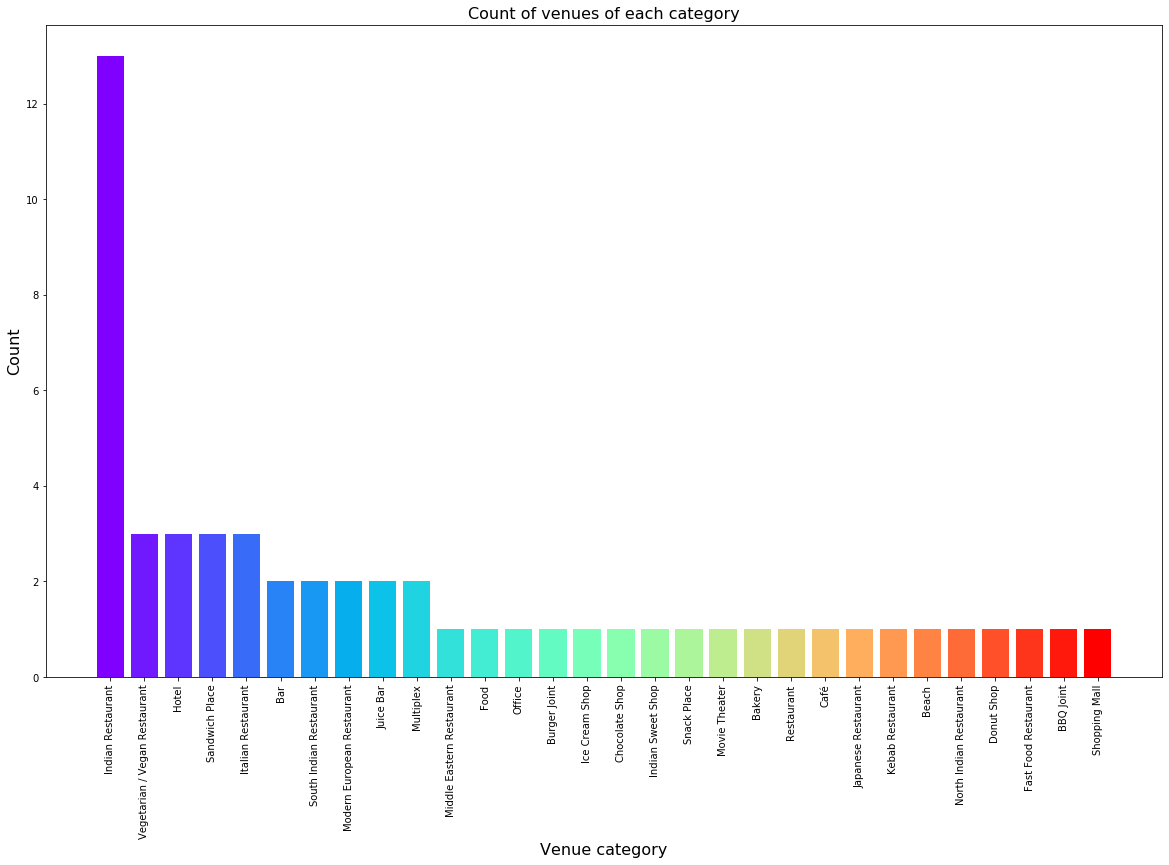

In [17]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

### <b>Rating</b> 
Visulaizing the ratings of the venues from the API.

Text(0.5, 1.0, 'Count of venues with given rating')

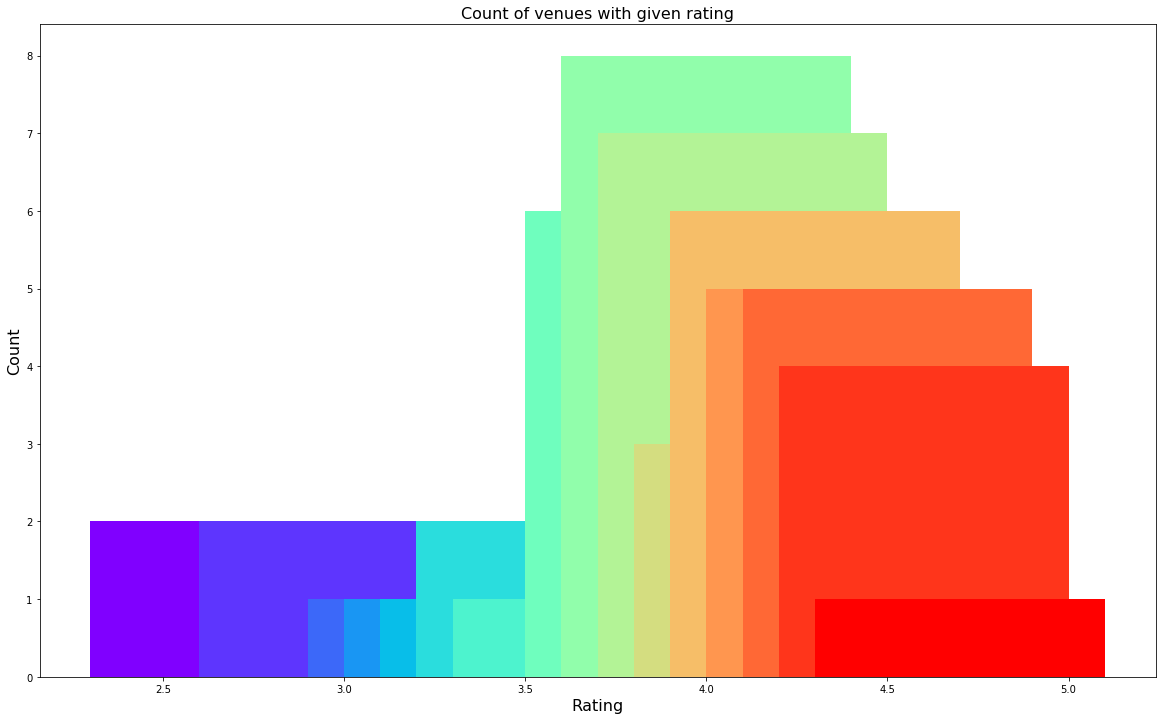

In [18]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

from the plot above we can clearly see the ratings of the majority of the venues are close to 4.

In [19]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

Plotting venues on the map.

In [20]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

chennai_map = folium.Map(location = [C_LATITUDE, C_LONGITUDE], zoom_start = 11)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(chennai_map)  

chennai_map.save("desktop/Venues Ratings.html")
chennai_map

### <b>Price</b>
We will now take a look the venues based on the price values. We have two price features for our venues, one is average_price which defines the average cost for one person and the other is price_range which determines the price range as defined by Zomato.

We will first explore the average_price using a scatter plot between the price and the count of venues with that average price. We'll size the points based on the price to highlight their price.

Text(0.5, 1.0, 'Count of venues with given average price')

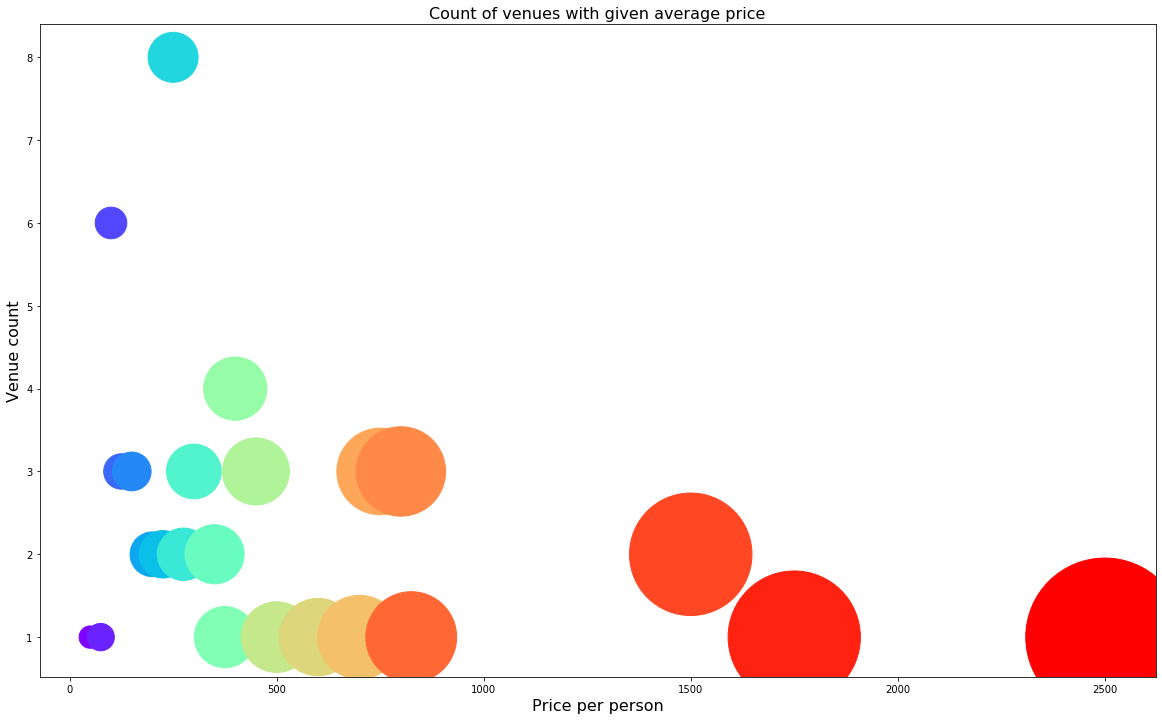

In [21]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

The plot clearly shows that the large number of venues have average price 100-900.<br>
Users might also be interested in going to a place that fits in their budget. I'll use the price_range column to plot the venues on a map. We'll represent the venues with lower price in green and move towards red as the price increases.

In [22]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

chennai_map = folium.Map(location = [C_LATITUDE, C_LONGITUDE], zoom_start = 11)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(chennai_map)  

chennai_map.save("desktop/Venues Prices.html")
chennai_map

### <b>Clustering</b>
We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into two separate groups.

In [ ]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)

In [24]:
selected_venues.head(10)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
1,0,Snack Place,Links,13.0799,80.2545,1.0,4.0,"22, Raja Annamalai Road, Purasavakkam, Chennai",125.0,Good
2,0,Indian Restaurant,Shree Mithai,13.0722,80.2479,1.0,4.6,"18, Dr TV Road, Chetpet, Chennai",150.0,Very good
3,0,Movie Theater,ID,13.0554,80.2581,1.0,4.5,"8, 1st Floor, Sathyam Cinemas Complex, Thiruvi...",150.0,Very good
4,0,Juice Bar,The Cake World,13.0604,80.2546,2.0,3.6,"11/2, Greams Road, Near Police Station, Thousa...",250.0,Good
5,0,Multiplex,ID,13.0554,80.2581,1.0,4.5,"8, 1st Floor, Sathyam Cinemas Complex, Thiruvi...",150.0,Very good
6,0,Chocolate Shop,Sandy's Chocolate Laboratory,13.0609,80.2483,3.0,4.4,"16, Wallace Garden, 2nd Street, Nungambakkam, ...",700.0,Very good
7,1,Bar,Blend - Taj Club House,13.0613,80.2642,4.0,4.1,"Taj Club House Hotel, 2, Club House Road, Ann...",2500.0,Very good
8,0,Shopping Mall,Pappa Roti,13.0587,80.2642,2.0,2.7,"Shop S 129, 1st Floor, Express Avenue Mall, Mh...",400.0,Okay
9,0,Indian Restaurant,Hotel Saravana Bhavan,13.0615,80.2621,2.0,3.4,"Ground Floor, Phase 1, Food Court, Spencer Pla...",275.0,Good
10,0,Ice Cream Shop,Amadora Gourmet Ice Cream & Sorbet,13.0609,80.2495,2.0,4.7,"23, Wallace Garden, 3rd Street, Nungambakkam, ...",250.0,Very good


In [27]:
chennai_map = folium.Map(location = [C_LATITUDE, C_LONGITUDE], zoom_start = 11)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(chennai_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(chennai_map)

chennai_map.save("desktop/Venues Clusters.html")
chennai_map

From the map, we see the two clusters:

The first cluster is spread across the whole city and includes the majority venues.<br>
The second cluster is very sparsely spread and has very limited venues.<br>
I'll also check the venues of the two clusters.

In [28]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Snack Place,Links,13.0799,80.2545,1.0,4.0,"22, Raja Annamalai Road, Purasavakkam, Chennai",125.0,Good
1,0,Indian Restaurant,Shree Mithai,13.0722,80.2479,1.0,4.6,"18, Dr TV Road, Chetpet, Chennai",150.0,Very good
2,0,Movie Theater,ID,13.0554,80.2581,1.0,4.5,"8, 1st Floor, Sathyam Cinemas Complex, Thiruvi...",150.0,Very good
3,0,Juice Bar,The Cake World,13.0604,80.2546,2.0,3.6,"11/2, Greams Road, Near Police Station, Thousa...",250.0,Good
4,0,Multiplex,ID,13.0554,80.2581,1.0,4.5,"8, 1st Floor, Sathyam Cinemas Complex, Thiruvi...",150.0,Very good
5,0,Chocolate Shop,Sandy's Chocolate Laboratory,13.0609,80.2483,3.0,4.4,"16, Wallace Garden, 2nd Street, Nungambakkam, ...",700.0,Very good
6,0,Shopping Mall,Pappa Roti,13.0587,80.2642,2.0,2.7,"Shop S 129, 1st Floor, Express Avenue Mall, Mh...",400.0,Okay
7,0,Indian Restaurant,Hotel Saravana Bhavan,13.0615,80.2621,2.0,3.4,"Ground Floor, Phase 1, Food Court, Spencer Pla...",275.0,Good
8,0,Ice Cream Shop,Amadora Gourmet Ice Cream & Sorbet,13.0609,80.2495,2.0,4.7,"23, Wallace Garden, 3rd Street, Nungambakkam, ...",250.0,Very good
9,0,Kebab Restaurant,Kabab Corner,13.0599,80.2545,1.0,4.6,"12/1, Opposite Royal Enfield Showroom, Egmore,...",225.0,Very good


In [29]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 1.84 and rating spread around 4.04


In [30]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Bar,Blend - Taj Club House,13.0613,80.2642,4.0,4.1,"Taj Club House Hotel, 2, Club House Road, Ann...",2500.0,Very good
1,1,Hotel,Library Blu - The Leela Palace,13.0171,80.2740,4.0,4.1,"The Leela Palace, Adyar Seaface, MRC Nagar, Ch...",1500.0,Very good
2,1,Hotel,The Dining Room - Park Hyatt,13.0107,80.2235,4.0,3.7,"Park Hyatt Chennai, 39, Velachery Road, Guindy...",1500.0,Good
3,1,Restaurant,The Flying Elephant - Park Hyatt,13.0104,80.2235,4.0,4.6,"39, Park Hyatt Chennai, Velachery Road, Guindy...",1750.0,Very good


In [31]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 4.00 and rating spread around 4.12


## <b>Results and Discussion</b> 
Based on our analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting the city of Chennai, India.

After collecting data from the Foursquare and Zomato APIs, we got a list of 102 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of 55.

We identified that from the total set of venues, majority of them were Fast food  and Indian Restaurants. A visitor who loves Fast food/Indian Restaurants would surely benefit from coming to Chennai.

While the complete range of ratings range from 1 to 5, the majority venues have ratings close to 4. This means that most restaurants provide good quality food which is liked by the people of the city, thus indicating the high rating. When we plot these venues on the map, we discover that there are clusters of venues around Guindy, roaypettah and Royapettah. These clusters also have very high ratings (more than 3).

When we take a look at the price values of each venue, we explore that many venues have prices which are in the range of Rs 100 to Rs 900 for one person. However, the variation in prices is very large, given the complete range starts from Rs 100 and goes uptil Rs 1200. On plotting the venues based on their price range on the map, we discovered that venues located near Anna Nagar and  are relatively priced lower than venues in Guindy and MRC Nagar . A mix of low price and high price exist in Thousand Lights.

Finally, through clusters we identified that there are many venues which are relatively lower priced but have an average rating of 4.04. On the other hand, there are few venues which are high priced and have average rating of 4.12.

If you're looking for cheap places with relatively high rating, you should check Tambaram.
If you're looking for the best places, with the highest rating but might also carry a high price tag, you should visit GUindy and MRC Nagar
If you're looking to explore the city and have no specific criteria to decide upon the places you want to visit, you should try Thousand Lights.
A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price).